
# Modelo Utilizado e Justificativas

Neste projeto, optou-se por usar um modelo LSTM (Long Short-Term Memory), que é um tipo de rede neural recorrente (RNN). As LSTMs são especialmente eficazes para modelagem de séries temporais, como os preços de criptomoedas, por terem a capacidade de capturar dependências de longo prazo nos dados. Isso é importante, pois os preços de mercado tendem a ser influenciados por valores históricos, e o LSTM pode lembrar de padrões que ocorreram no passado e que afetam os valores futuros.

As LSTMs se destacam em prever valores futuros com base em sequências anteriores, uma vez que seus "células de memória" permitem que a rede mantenha informações relevantes durante a análise de longas sequências de dados. No caso do preço do Bitcoin, os valores anteriores são uma forte indicação de possíveis movimentos futuros, o que torna esse modelo particularmente adequado para prever o preço de fechamento.


In [1]:
# Instalação de Pacotes
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pillow-10.4.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 15.6 MB/s eta 0:00:0031m15.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 20.0 MB/s eta 0:00:0031m20.6 MB/s eta 0:00:01
Using cached pillow-10.4.0-cp311-cp311-macosx_11_0_arm64.whl (3.4 MB)
  Created wheel for peewee: filename=peewee-3.17.6-cp311-cp311-macosx_14_0_arm64.whl size=250712 sha256=e571a5c4569278c24d95470ca707c549be7e6c4aafe8935139ee73b97dbbbd2d
  

In [2]:
# Importação de Bibliotecas
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

%matplotlib inline
plt.style.use('seaborn')


OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [12]:

today = datetime.today()
df = yf.download('BTC-USD', start='2015-01-01', end=today)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Usar colunas selecionadas
df.head(100)


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800
...,...,...,...,...,...
2015-04-06,260.721008,261.798004,254.574997,255.492004,20034200
2015-04-07,255.274002,255.804993,252.205002,253.179993,18467400
2015-04-08,253.063995,253.847000,244.214996,245.022003,30086400


In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))


In [13]:
# Função para Criar Sequências
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60

X, y = create_sequences(scaled_data, seq_length)

X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
# Divisão em Treino e Teste
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Bloco de Atenção

A inclusão de um bloco de atenção foi adicionada para melhorar o desempenho do modelo. Embora o LSTM capture dependências temporais, nem todas as informações na sequência têm o mesmo peso para a previsão. O bloco de atenção foi introduzido para permitir que o modelo dê mais importância a certos pontos na sequência que são mais relevantes para a previsão.

O mecanismo de atenção calcula "pesos de atenção" que indicam a importância de cada passo no tempo dentro da sequência. Esses pesos são aplicados às saídas da camada LSTM, ajustando os dados que o modelo utiliza para tomar sua decisão final. O bloco de atenção, portanto, ajuda o modelo a se concentrar nas partes mais significativas da sequência, melhorando a precisão da previsão ao destacar as informações mais úteis.



In [15]:
# Função do Bloco de Atenção
def attention_block(inputs):
    attention_weights = layers.Dense(1, activation='tanh')(inputs)
    attention_weights = layers.Flatten()(attention_weights)
    attention_weights = layers.Activation('softmax')(attention_weights)
    attention_weights = layers.RepeatVector(inputs.shape[-1])(attention_weights)
    attention_weights = layers.Permute([2, 1])(attention_weights)

    weighted_inputs = layers.Multiply()([inputs, attention_weights])
    return weighted_inputs


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 60, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 60, 128)        │         66,560 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 60, 1)          │            129 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 60)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 60)             │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 128, 60)        │              0 │ activation[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 60, 128)        │              0 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 60, 128)        │              0 │ lstm_2[0][0],          │
│                           │                        │                │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 7680)           │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │        491,584 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 558,338 (2.13 MB)

 Trainable params: 558,338 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

# Estrutura do Modelo

O modelo híbrido criado é composto por uma camada LSTM, seguida pelo bloco de atenção para refinar a saída, e, finalmente, camadas densas para fazer a previsão do preço de fechamento.

Camada LSTM: A camada LSTM captura as dependências temporais do histórico de preços. Utilizamos 128 unidades LSTM, permitindo ao modelo reter informações suficientes sobre a sequência de entrada de 60 dias.

Bloco de Atenção: Aplica pesos de atenção às saídas do LSTM, permitindo que o modelo identifique os pontos mais relevantes dentro da sequência.

Camada Densa: Após o bloco de atenção, usamos uma camada densa com 64 neurônios para processar as informações e, por fim, uma camada de saída com um único neurônio, que gera a previsão do preço de fechamento.

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - mae: 0.0266
Test MAE: 0.03678290918469429


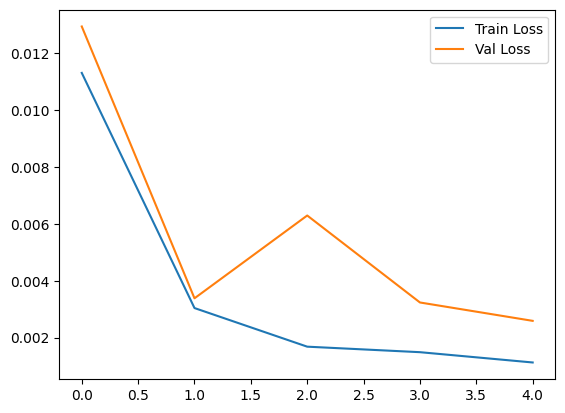

In [18]:
# Definição do Modelo LSTM com Atenção
def build_lstm_attention_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    lstm_out = layers.LSTM(128, return_sequences=True)(inputs)
    attention_out = attention_block(lstm_out)
    combined_out = layers.Flatten()(attention_out)
    dense_out = layers.Dense(64, activation='relu')(combined_out)
    output = layers.Dense(1, activation='linear')(dense_out)
    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Definição do Modelo LSTM Simples
def build_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(128, input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Definição do Modelo GRU
def build_gru_model(input_shape):
    model = models.Sequential()
    model.add(layers.GRU(128, input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


# Treinamento e Avaliação

O modelo é compilado com o otimizador Adam, que é eficaz para modelos como LSTMs, e a função de perda escolhida é o erro quadrático médio (MSE), que é adequada para problemas de regressão, como a previsão de preços. O treinamento é interrompido precocemente utilizando a técnica de Early Stopping, que monitora a perda na validação e evita o overfitting, restaurando os melhores pesos quando a validação não melhora após algumas épocas.




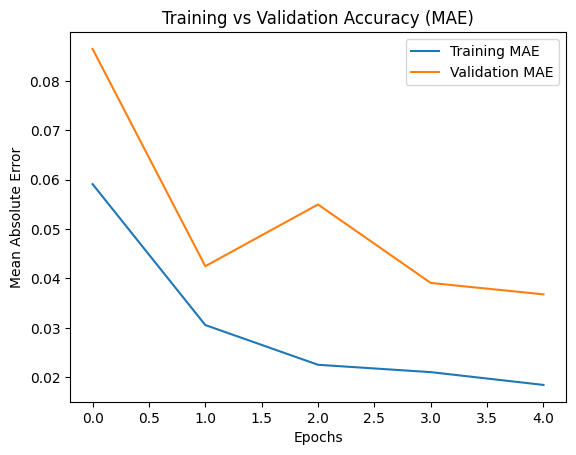

In [19]:
# Definição dos Modelos a Serem Treinados
models_dict = {
    'LSTM_Attention': build_lstm_attention_model((X_train.shape[1], 1)),
    'LSTM': build_lstm_model((X_train.shape[1], 1)),
    'GRU': build_gru_model((X_train.shape[1], 1))
}

# Dicionários para Armazenar Resultados
history_dict = {}
test_mae_dict = {}
test_mse_dict = {}


In [ ]:
# Treinamento dos Modelos Recorrentes
for name, model in models_dict.items():
    print(f'Treinando o modelo: {name}')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    history_dict[name] = history
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    test_mse = test_loss
    test_mae_dict[name] = test_mae
    test_mse_dict[name] = test_mse
    print(f'{name} - Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}\n')


In [21]:
# Regressão Linear como Baseline
print('Treinando o modelo: Regressão Linear (Baseline)')

# Preparar dados para Regressão Linear
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1])

lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)
y_pred_lr = lr_model.predict(X_test_flat)
y_pred_lr_inv = scaler.inverse_transform(y_pred_lr.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Avaliação do Modelo de Regressão Linear
test_mae_lr = mean_absolute_error(y_test_inv, y_pred_lr_inv)
test_mse_lr = mean_squared_error(y_test_inv, y_pred_lr_inv)
test_mae_dict['LinearRegression'] = test_mae_lr
test_mse_dict['LinearRegression'] = test_mse_lr
print(f'Regressão Linear - Test MAE: {test_mae_lr:.4f}, Test MSE: {test_mse_lr:.4f}\n')


In [22]:
# Comparação das Métricas
metrics_df = pd.DataFrame({
    'Modelo': list(test_mae_dict.keys()),
    'MAE': list(test_mae_dict.values()),
    'MSE': list(test_mse_dict.values())
})

metrics_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Next Day Prediction: [56657.535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Next Week Predictions: [56657.535, 56954.742, 57137.727, 57226.59, 57226.082, 57164.53, 57021.97]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/

In [ ]:
# Plot das Perdas de Treinamento e Validação
plt.figure(figsize=(14, 8))
for name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{name} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'{name} - Val Loss')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:
# Plot das Métricas de MAE
plt.figure(figsize=(10,6))
plt.bar(metrics_df['Modelo'], metrics_df['MAE'], color=['blue', 'orange', 'green', 'red'])
plt.title('Comparação de MAE entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.show()


In [ ]:
# Plot das Métricas de MSE
plt.figure(figsize=(10,6))
plt.bar(metrics_df['Modelo'], metrics_df['MSE'], color=['blue', 'orange', 'green', 'red'])
plt.title('Comparação de MSE entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.show()


In [ ]:
# Selecionando o modelo com menor MAE
best_model_name = metrics_df.sort_values('MAE').iloc[0]['Modelo']
print(f'Melhor Modelo: {best_model_name}')


In [ ]:
# Obtenção das Previsões do Melhor Modelo
if best_model_name == 'LinearRegression':
    y_pred_best = y_pred_lr_inv
else:
    best_model = models_dict[best_model_name]
    y_pred_best_scaled = best_model.predict(X_test)
    y_pred_best = scaler.inverse_transform(y_pred_best_scaled)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:
# Plot das Previsões vs Valores Reais
plt.figure(figsize=(14,8))
plt.plot(y_test_actual, color='blue', label='Preço Real')
plt.plot(y_pred_best, color='red', label='Preço Previsto')
plt.title(f'Preço Real vs Previsão ({best_model_name})')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.show()


In [ ]:
# Função para Prever Preços Futuros
def predict_future_prices(model, data, scaler, sequence_length, steps, model_name=''):
    """
    Prever preços futuros para um determinado número de passos (dias).

    model: Modelo treinado.
    data: Última sequência de dados para previsões (escalonados).
    scaler: Objeto Scaler para reverter o escalonamento.
    sequence_length: Comprimento da sequência usada pelo modelo (ex: 60 dias).
    steps: Número de passos futuros para prever (ex: 1 para dia, 7 para semana, etc.).
    model_name: Nome do modelo para tratamento específico (ex: LinearRegression).

    Retorna:
    predictions: Array de preços futuros previstos (não escalonados).
    """
    current_sequence = data[-sequence_length:]
    future_predictions = []

    for _ in range(steps):
        if model_name == 'LinearRegression':
            current_sequence_flat = current_sequence.reshape(1, -1)
            predicted_price_scaled = model.predict(current_sequence_flat)
        else:
            current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))
            predicted_price_scaled = model.predict(current_sequence_reshaped)
        
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        future_predictions.append(predicted_price)
        
        predicted_price_scaled = scaler.transform(np.array([[predicted_price]]))
        current_sequence = np.append(current_sequence, predicted_price_scaled)[-sequence_length:]
    
    return future_predictions


In [ ]:
# Obter a Última Sequência para Previsão
last_sequence = scaled_data[-seq_length:]

# Previsões Futuras com o Melhor Modelo
next_day_prediction = predict_future_prices(
    models_dict.get(best_model_name, lr_model), 
    last_sequence, 
    scaler, 
    seq_length, 
    steps=1,
    model_name=best_model_name
)
print(f'Previsão para o Próximo Dia: {next_day_prediction}')

next_week_predictions = predict_future_prices(
    models_dict.get(best_model_name, lr_model), 
    last_sequence, 
    scaler, 
    seq_length, 
    steps=7,
    model_name=best_model_name
)
print(f'Previsões para a Próxima Semana: {next_week_predictions}')

next_month_predictions = predict_future_prices(
    models_dict.get(best_model_name, lr_model), 
    last_sequence, 
    scaler, 
    seq_length, 
    steps=30,
    model_name=best_model_name
)
print(f'Previsões para o Próximo Mês: {next_month_predictions}')


In [ ]:
# Plot das Previsões Futuros
plt.figure(figsize=(14,8))
plt.plot(y_test_actual, color='blue', label='Preço Real')
plt.plot(y_pred_best, color='red', label='Preço Previsto')
future_steps = range(len(y_test_actual), len(y_test_actual) + len(next_month_predictions))
plt.plot(future_steps, next_month_predictions, color='green', label='Previsão Futura (30 dias)')
plt.title(f'Preço Real vs Previsão ({best_model_name}) com Previsões Futuras')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.show()
